In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import scipy.constants as const
from beam.beams import electronbeam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from beam import interactions
from lens import profile
from scipy.interpolate import interp1d

path = '/media/robert/Data_Storage/Data/Super-Adiabatic_Ramp_Propagation/Analytic_Plasma/'

In [2]:
N = 10000
z = np.linspace(0, 1.5, N)
dz = 1.5/(N-1)
beta = np.zeros(N, dtype='double')
betap = np.zeros(N, dtype='double')
betapp = np.zeros(N, dtype='double')

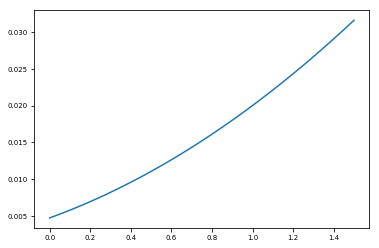

In [3]:
beta[0] = 4.75544783085e-3
betap[0] = 0.01
betapp[0] = betap[0]**2/(2*beta[0])
for i in range(1, N):
    betap[i] = betap[i-1] + betapp[i-1]*dz
    beta[i] = beta[i-1] + (betap[i-1]+betap[i])*dz/2
    betapp[i] = ((betap[i]+betap[i-1])/2)**2/(beta[i]+beta[i-1])
    
plt.plot(z, beta)
plt.show()

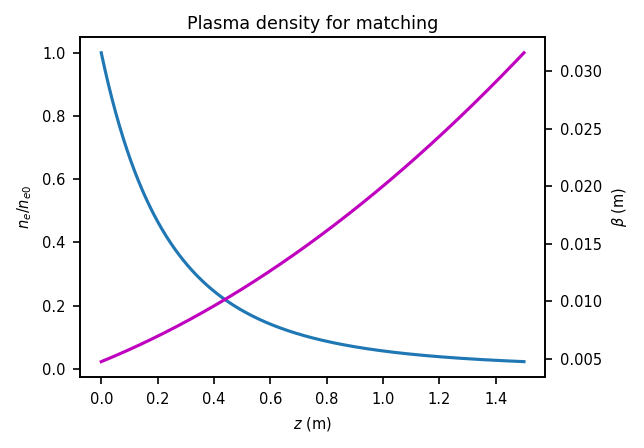

In [4]:
# Calculate the plasma density necessary to create this profile
ne = beta[0]**2/beta**2
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(z, ne)
plt.title('Plasma density for matching')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$n_e/n_{e0}$')
plt.twinx()
plt.plot(z, beta, 'm')
plt.ylabel(r'$\beta$ (m)')
plt.show()

In [5]:
# Create the plasma desnity
fne = interp1d(z*1e6, ne*0.5)
Nz = 1000
zsim = np.linspace(0, 1.5, Nz)
zsim *= 1e6
#ne = fne(zsim)
class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return fne(z)
    def dgammadz(self, ne):
        return 0.0
plasmaDen = plasmaCls()

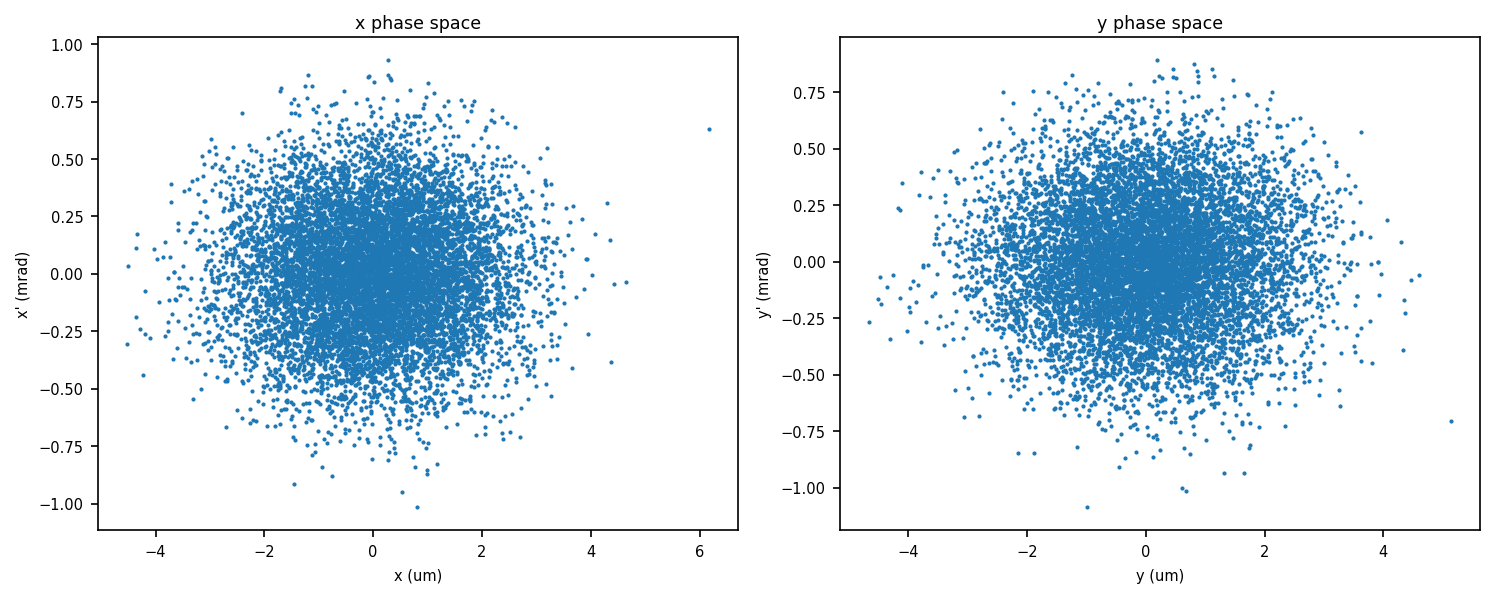

In [6]:
# Create the electron beam
gamma = 20000 # Beam relativistic Lorentz factor
betaBeam = beta[0]
alphaBeam = betap[0]/(-2)
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : gamma,
    'emittance' : 7e-6,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

In [7]:
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, zsim, dumpPer, 4)
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, 1.5, m)
dz = 1.5/(m-1)
beam_ne = fne(beam_z*1e6)

Initial emittance: 6.9381 um rad
Final emittance:   6.9372 um rad


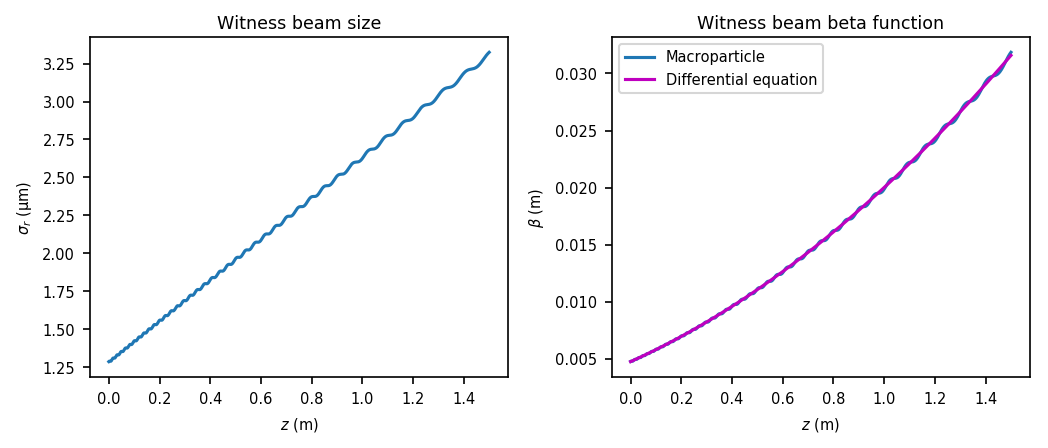

In [8]:
# Check to make sure everything seems correct
beam_sigmar = np.zeros(m, dtype='double')
beam_eps = np.zeros(m, dtype='double')
for i in range(m):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))
    beam_eps[i] = np.average(beam.get_emittance_n(i))
beam_beta = (beam_sigmar)**2 / beam_eps * gamma
print('Initial emittance: %0.4f um rad' % (beam_eps[0]*1e6))
print('Final emittance:   %0.4f um rad' % (beam_eps[m-1]*1e6))

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.title('Witness beam size')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta)
plt.plot(z, beta, 'm')
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')
plt.legend(['Macroparticle', 'Differential equation'])

plt.tight_layout()
plt.show()

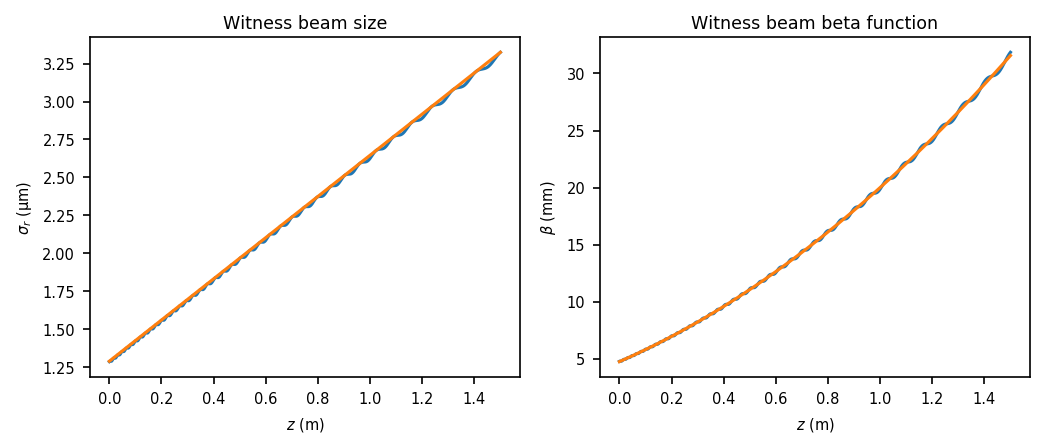

0.00475306951221
1.28979623556


In [9]:
# Lets look at the region right before the ramp more carefully
eps0 = const.physical_constants['electric constant'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
c = const.physical_constants['speed of light in vacuum'][0]
sigmaM = np.sqrt(c*np.sqrt(me*eps0/beam_ne/1e23/e**2)*1e6*np.sqrt(2*gamma)*7.0/gamma)
betaM = (sigmaM*1e-6)**2 / 7e-6 * gamma

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.plot(beam_z, sigmaM)
plt.title('Witness beam size')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta*1e3)
plt.plot(beam_z, betaM*1e3)
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (mm)')

plt.tight_layout()
plt.show()
print(betaM[0])
print(sigmaM[0])

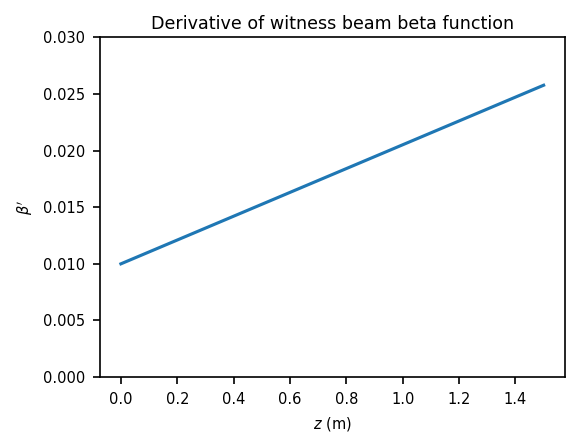

In [26]:
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(z, betap)
#plt.plot(beam_z, betaM*1e3)
plt.title('Derivative of witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta'$")
#plt.xlim([1.0, 1.6])
plt.ylim(0, .03)
plt.show()